In [5]:
import torch
import pandas as pd
import numpy as np
from utils.GraphConvolution import GCN_Encoder_s, GCN_Classifier_s, Decoder_s
from utils.GraphConvolution import GraphConvolution, GCN_Encoder3
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import utils
from collections import defaultdict

Initialization

In [6]:
class Args:
    weight_decay = 5e-4
    epochs = 1000
    learning_rate = 0.01
    learning_rate_W = 0.01
    dropout = 0.5
    dropout_W = 0.5
    gamma = 1
    no_cuda = False
    train_ratio=0.6
    test_ratio=0.2
    n_classes = 2
    seed = 12345
    torch.manual_seed(seed)
    # dataset = "cora"
    # dataset = "haberman"
    dataset = "diabetes"
    order = 4
    n_features = 0
    w_val_size = 10
    imbalance_ratio = None
    n_hidden = 64
    setting = None
    im_class_num = 1
    setting = "upsampling"
    opt_new_G = False
    up_scale = 1
    im_ratio = 0.5
args = Args()


Dataset specific variables

In [7]:
from utils.data_loader import data_loader_diabetes, data_loader_haberman, data_loader_cora

cora_adj_mtx, cora_labels_df, cora_features_df, \
        cora_train_idx, cora_val_idx, cora_test_idx, cora_n_features = data_loader_cora(args)
        
diabetes_adj_mtx, diabetes_labels_df, diabetes_features_df, \
        diabetes_train_idx, diabetes_val_idx, diabetes_test_idx, diabetes_n_features = data_loader_diabetes(args)

haberman_adj_mtx, haberman_labels_df, haberman_features_df, \
        haberman_train_idx, haberman_val_idx, haberman_test_idx, haberman_n_features = data_loader_haberman(args)

if args.dataset == "diabetes":
    adj_mtx = diabetes_adj_mtx
    n_hidden = [64, 64, 64]
    n_features = diabetes_n_features
    features = diabetes_features_df
    labels = diabetes_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = diabetes_train_idx
    val_idx = diabetes_val_idx
    test_idx = diabetes_test_idx
elif args.dataset == "cora":
    adj_mtx = cora_adj_mtx
    n_hidden = [64, 64, 64]
    n_features = cora_n_features
    features = cora_features_df
    labels = cora_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = cora_train_idx
    val_idx = cora_val_idx
    test_idx = cora_test_idx
elif args.dataset == "haberman":
    adj_mtx = haberman_adj_mtx
    n_hidden = [64]
    n_features = haberman_n_features
    features = haberman_features_df
    labels = haberman_labels_df
    # train_X = haberman_train_X_df
    # train_Y = haberman_train_Y_df
    # val_X = haberman_val_X_df
    # val_Y = haberman_val_Y_df
    # test_X = haberman_test_X_df
    # test_Y = haberman_test_Y_df
    train_idx = haberman_train_idx
    val_idx = haberman_val_idx
    test_idx = haberman_test_idx
else:
    pass

In [8]:
# assert len(pd.DataFrame(labels[train_idx])[0].unique()) == len(pd.DataFrame(labels[val_idx])[0].unique()) == len(pd.DataFrame(labels[test_idx])[0].unique()), \
#     "There are some classes missing in one the 3 partitiones of the dataset"

In [9]:
device = torch.device("cuda" if False else "cpu")

Dataframe to Tensor transformation

In [10]:
# features = torch.from_numpy(np.concatenate((train_X, val_X, test_X), axis=0)).to(device)
# labels = torch.from_numpy(np.int64(np.concatenate((train_Y, val_Y, test_Y), axis=0))).to(device)
train_idx = torch.from_numpy(np.array(train_idx, dtype = np.int64)).to(device)
val_idx = torch.from_numpy(np.array(val_idx, dtype = np.int64)).to(device)
test_idx = torch.from_numpy(np.array(test_idx, dtype = np.int64)).to(device)
features = torch.from_numpy(np.array(features, dtype = np.float64)).to(device)
labels = torch.from_numpy(np.array(labels, dtype = np.int64)).to(device)
try:
    adj_mtx = torch.from_numpy(np.array(adj_mtx, dtype = np.float64)).to(device)
except:
    pass

Classifier

In [11]:
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc

# encoder = GCN_Encoder3(nfeat=n_features,
#         nhid=n_hidden,
#         nembed=n_hidden[-1],
#         dropout=args.dropout,
#         nclass=args.n_classes,
#         order=1)
# classifier = GCN_Classifier(nembed=n_hidden[-1], 
#         nhid=n_hidden[-1], 
#         nclass=int(labels.max().item()) + 1, 
#         dropout=args.dropout, device=device)
encoder = GCN_Encoder_s(nfeat = n_features, nhid = n_hidden[-1], nembed = n_hidden[-1], dropout = args.dropout)
classifier = GCN_Classifier_s(nembed = n_hidden[-1], nhid = n_hidden[-1], nclass = int(labels.max().item()) + 1, dropout = args.dropout, device = device)
optimizer_en = optim.Adam(encoder.parameters(),
                       lr = args.learning_rate, weight_decay = args.weight_decay)
optimizer_cls = optim.Adam(classifier.parameters(),
                       lr = args.learning_rate, weight_decay = args.weight_decay)
encoder.train()
classifier.train()
def train(epoch):
        t = time.time()
        optimizer_en.zero_grad()
        optimizer_cls.zero_grad()
        embed = encoder(features, adj_mtx)
        output = classifier(embed, adj_mtx)
        out = output[train_idx]
        gt = labels[train_idx].reshape(-1)
        if args.setting == 'reweight':
                weight = "STH"
                loss_train = F.cross_entropy(out, gt, weight = weight)
        else:
                loss_train = F.cross_entropy(out, gt)
        acc_train = accuracy(out, gt)
        loss_train.backward()
        optimizer_en.step()
        optimizer_cls.step()
        gt_v = labels[test_idx].reshape(-1)
        out_v = output[test_idx]
        loss_val = F.cross_entropy(out_v, gt_v)
        acc_val = accuracy(out_v, gt_v)
        # print_class_acc(out_v, gt_v)
        print('Epoch: {:05d}'.format(epoch+ 1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
        
        return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()


In [12]:
acc_trains = []
acc_vals = []
loss_trains = []
loss_vals = []

for epoch in range(args.epochs):
        acc_train, acc_val, loss_train, loss_val = train(epoch)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        loss_trains.append(loss_train)
        loss_vals.append(loss_val)

Epoch: 00001 loss_train: 10208.4686 acc_train: 0.4500 loss_val: 11054.1048 acc_val: 0.4091 time: 0.0248s
Epoch: 00002 loss_train: 22299.7362 acc_train: 0.6522 loss_val: 20013.5462 acc_val: 0.6494 time: 0.0187s
Epoch: 00003 loss_train: 6761.6032 acc_train: 0.6413 loss_val: 6606.7487 acc_val: 0.6234 time: 0.0195s
Epoch: 00004 loss_train: 3793.2409 acc_train: 0.5022 loss_val: 4248.3098 acc_val: 0.4870 time: 0.0186s
Epoch: 00005 loss_train: 1047.7026 acc_train: 0.5457 loss_val: 1419.8706 acc_val: 0.5130 time: 0.0247s
Epoch: 00006 loss_train: 1197.4908 acc_train: 0.6435 loss_val: 1082.0656 acc_val: 0.6169 time: 0.0282s
Epoch: 00007 loss_train: 875.7768 acc_train: 0.6391 loss_val: 613.3173 acc_val: 0.6494 time: 0.0237s
Epoch: 00008 loss_train: 673.2004 acc_train: 0.4457 loss_val: 945.5011 acc_val: 0.4675 time: 0.0274s
Epoch: 00009 loss_train: 388.6753 acc_train: 0.5457 loss_val: 425.8187 acc_val: 0.5519 time: 0.0262s
Epoch: 00010 loss_train: 205.2893 acc_train: 0.5652 loss_val: 166.3254 acc_

KeyboardInterrupt: 

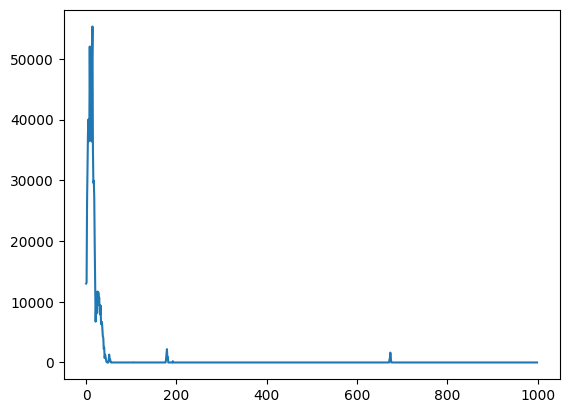

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

# %matplotlib notebook
# %matplotlib inline

plt.plot(loss_vals)

plt.show()

GraphSMOTE's implementation

In [11]:
from copy import deepcopy

encoder_s = GCN_Encoder_s(nfeat=features.shape[1],
        nhid=args.n_hidden,
        nembed=args.n_hidden,
        dropout=args.dropout)
classifier_s = GCN_Classifier_s(nembed=args.n_hidden, 
        nhid=args.n_hidden, 
        nclass=labels.max().item() + 1, 
        dropout=args.dropout, device = device)
decoder_s = Decoder_s(nembed=args.n_hidden,
        dropout=args.dropout)
optimizer_en = optim.Adam(encoder_s.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
optimizer_cls = optim.Adam(classifier_s.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
optimizer_de = optim.Adam(decoder_s.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
def train(epoch):
    t = time.time()
    encoder_s.train()
    classifier_s.train()
    decoder_s.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder(features, adj_mtx)

    if args.setting == 'recon_newG' or args.setting == 'recon' or args.setting == 'newG_cls':
        ori_num = labels.shape[0]
        embed, labels_new, idx_train_new, adj_up = utils.recon_upsample(embed, labels, train_idx, adj = adj_mtx.detach().to_dense(), portion = args.up_scale, im_class_num = args.im_class_num)
        generated_G = decoder_s(embed)

        loss_rec = utils.adj_mse_loss(generated_G[: ori_num, :][:, : ori_num], adj_mtx.detach().to_dense())
        
        #ipdb.set_trace()


        if not args.opt_new_G:
            adj_new = copy.deepcopy(generated_G.detach())
            threshold = 0.5
            adj_new[adj_new < threshold] = 0.0
            adj_new[adj_new >= threshold] = 1.0

            #ipdb.set_trace()
            edge_ac = adj_new[: ori_num, : ori_num].eq(adj_mtx.to_dense()).double().sum()/(ori_num**2)
        else:
            adj_new = generated_G
            edge_ac = F.l1_loss(adj_new[: ori_num, : ori_num], adj_mtx.to_dense(), reduction = 'mean')


        #calculate generation information
        exist_edge_prob = adj_new[:ori_num, :ori_num].mean() #edge prob for existing nodes
        generated_edge_prob = adj_new[ori_num:, :ori_num].mean() #edge prob for generated nodes
        print("edge acc: {:.4f}, exist_edge_prob: {:.4f}, generated_edge_prob: {:.4f}".format(edge_ac.item(), exist_edge_prob.item(), generated_edge_prob.item()))


        adj_new = torch.mul(adj_up, adj_new)

        exist_edge_prob = adj_new[:ori_num, :ori_num].mean() #edge prob for existing nodes
        generated_edge_prob = adj_new[ori_num:, :ori_num].mean() #edge prob for generated nodes
        print("after filtering, edge acc: {:.4f}, exist_edge_prob: {:.4f}, generated_edge_prob: {:.4f}".format(edge_ac.item(), exist_edge_prob.item(), generated_edge_prob.item()))


        adj_new[:ori_num, :][:, :ori_num] = adj_mtx.detach().to_dense()
        #adj_new = adj_new.to_sparse()
        #ipdb.set_trace()

        if not args.opt_new_G:
            adj_new = adj_new.detach()

        if args.setting == 'newG_cls':
            idx_train_new = train_idx

    elif args.setting == 'embed_up':
        #perform SMOTE in embedding space
        embed, labels_new, idx_train_new = utils.recon_upsample(embed, labels, train_idx, portion=args.up_scale, im_class_num = args.im_class_num)
        adj_new = adj_mtx
    else:
        labels_new = labels
        idx_train_new = train_idx
        adj_new = adj_mtx

    #ipdb.set_trace()
    output = classifier_s(embed, adj_new)



    if args.setting == 'reweight':
        weight = features.new((labels.max().item() + 1)).fill_(1)
        weight[-args.im_class_num:] = 1 + args.up_scale
        loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new].reshape(-1), weight=weight)
    else:
        loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new].reshape(-1))

    acc_train = accuracy(output[train_idx], labels_new[train_idx].reshape(-1))
    if args.setting == 'recon_newG':
        loss = loss_train + loss_rec * args.rec_weight
    elif args.setting == 'recon':
        loss = loss_rec + 0 * loss_train
    else:
        loss = loss_train
        loss_rec = loss_train

    loss.backward()
    if args.setting == 'newG_cls':
        optimizer_en.zero_grad()
        optimizer_de.zero_grad()
    else:
        optimizer_en.step()

    optimizer_cls.step()

    if args.setting == 'recon_newG' or args.setting == 'recon':
        optimizer_de.step()

    loss_val = F.cross_entropy(output[val_idx], labels[val_idx].reshape(-1))
    acc_val = accuracy(output[val_idx], labels[val_idx].reshape(-1))

    print('Epoch: {:05d}'.format(epoch + 1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

for epoch in range(args.epochs):
    train(epoch)

Epoch: 00001 loss_train: 7260.1679 loss_rec: 7260.1679 acc_train: 0.4412 loss_val: 10124.0106 acc_val: 0.4355 time: 0.0050s
Epoch: 00002 loss_train: 320.8344 loss_rec: 320.8344 acc_train: 0.9853 loss_val: 17279.4603 acc_val: 0.7097 time: 0.0040s
Epoch: 00003 loss_train: 428.6254 loss_rec: 428.6254 acc_train: 0.9926 loss_val: 25191.0579 acc_val: 0.7097 time: 0.0033s
Epoch: 00004 loss_train: 797.2419 loss_rec: 797.2419 acc_train: 0.9926 loss_val: 28697.5457 acc_val: 0.7258 time: 0.0030s
Epoch: 00005 loss_train: 508.1976 loss_rec: 508.1976 acc_train: 0.9926 loss_val: 31478.7595 acc_val: 0.7258 time: 0.0040s
Epoch: 00006 loss_train: 392.8181 loss_rec: 392.8181 acc_train: 0.9926 loss_val: 36842.1025 acc_val: 0.7258 time: 0.0031s
Epoch: 00007 loss_train: 612.0097 loss_rec: 612.0097 acc_train: 0.9926 loss_val: 36808.0675 acc_val: 0.7258 time: 0.0032s
Epoch: 00008 loss_train: 726.7453 loss_rec: 726.7453 acc_train: 0.9926 loss_val: 40227.7039 acc_val: 0.7258 time: 0.0033s
Epoch: 00009 loss_trai

train & eval

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import pickle


def encode_onehot_torch(labels):
    num_classes = int(labels.max() + 1)
    y = torch.eye(num_classes)
    return y[labels]


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot